BAMRUNG Premchanok
HUSTACHE Thomas 
VALDOM Janvier 2021

# Tutorial 2 - The Queens & The Art of Branching

**Important:** You must fully complete Tutorial $i-1$ before starting Tutorial $i$ ($i>1$).

Constraint programming is used to solve highly combinatorial and complex problems. 
In order to master CP, you need to get used to the philosophy behind this approach as well as the different 
techniques used along with it. We will guide you in this process step by step in the upcoming tutorials. We will be using "toy" puzzles/problems only for the purpose of learning different faces of CP. In real life problems, things get messed up easily and require decision and policy makes to agree opon the problem at hand.. (Trust us, we've been there..) 

In this tutorial, we use the N-Queens problem, one of oldest and classical problems solved efficiently by CP, as a case study. 

## 1. The N-Queens problem

You are given an N-by-N chessboard, and your goal is to place N chess queens on it so that no two queens threaten each other:

<div class="row" style="margin-top: 10px">
    <div class="col-md-5">
        <img src="display/images/empty-chessboard.png" style="margin-right: 0; width: 160px;" />
    </div>
    <div class="col-md-2" style="display: table">
        <i class="fa fa-arrow-right" style="display: table-cell; font-size: 50px; 
        margin: auto; text-align: center; vertical-align: middle; height: 150px"></i>
    </div>
    <div class="col-md-5">
        <img src="display/images/nqueens8-chessboard.png" style="margin-left: 0; width: 160px;" />
    </div>
</div>

Formally, a solution to the N-queens problem requires that no two queens share the same row, column or diagnoal.

### 1.1. Model without global constraints

**Exercice**: Create a function `decomposition_model(N)` that models the problem using only binary inequality constrants (no global constraint) and returns an instance of `CpoModel` for the n-queens problem with `N` queens.

In [1]:
from config import setup
setup()

In [2]:
from docplex.cp.config import context
context.solver.agent = 'local'
context.solver.local.execfile = '/home/prembamrung/ibm/ILOG/CPLEX_Studio129/cpoptimizer/bin/x86-64_linux/cpoptimizer'

In [3]:
from docplex.cp.model import CpoModel


def decomposition_model(N: int) -> CpoModel:
    mdl = CpoModel(name='Queens')
    lines = mdl.integer_var_list(N, 0, N-1, 'line')

    for i, col in enumerate(lines):

        for j, other_col in enumerate(lines):
            if j != i:

                k = i-j
                mdl.add(col != other_col+k)
                mdl.add(col != other_col-k)
                mdl.add(col != other_col)

    return mdl

**Exercice:** Test your function by solving the n-queens problem for small values of $N$ ($N < 20$).

<div class="alert alert-block alert-info">
    
Use the `display.n_queens` function in order to display a solution for the n-queens problem. This function can take a list of `int` corresponding to the column of the queens in order to display them.
    
</div>

In [4]:
from display import n_queens as display_queens
sol = decomposition_model(10).solve()
sol.print_solution()

# TODO

-------------------------------------------------------------------------------
Model constraints: 270, variables: integer: 10, interval: 0, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------

line_0: 6
line_1: 0
line_2: 2
line_3: 5
line_4: 7
line_5: 9
line_6: 3
line_7: 8
line_8: 4
line_9: 1


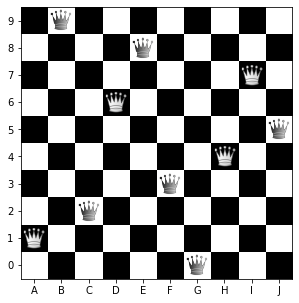

In [5]:
all_var = [sol.get_var_solution('line_'+str(i)) for i in range(10)]
my_values = [v.value for v in all_var]
display_queens(my_values)

**Question**: How many solutions are there for $N = 3,~\ldots,~10$? 

**Note:** To answer this question, you must force the solver to use a depth first strategy using  `CpoModel.start_search(SearchType="DepthFirst")`.

In [6]:
for i in range(3, 11):
    lsols = decomposition_model(i).start_search(SearchType="DepthFirst")
    nb_solutions = 0
    for sol in lsols:
        # sol.write()
        nb_solutions += 1
    print('i: ', i, " ", nb_solutions)

i:  3   0
i:  4   2
i:  5   10
i:  6   4
i:  7   40
i:  8   92
i:  9   352
i:  10   724


### 1.2. Model with global constraints

**Exercice:** Create a function `global_constraint_model(N)` that models and returns an instance of `CpoModel` for the n-queens problem with `N` queens, using **only** and exaclty 3 global constraints.

In [7]:
from docplex.cp.model import CpoModel


def global_constraint_model(N: int) -> CpoModel:

    mdl = CpoModel(name='Queens_global')
    lines = mdl.integer_var_list(N, 0, N-1, 'line')

    mdl.add(mdl.all_diff(lines))
    mdl.add(mdl.all_diff([lines[i]-i for i in range(N)]))
    mdl.add(mdl.all_diff([lines[i]+i for i in range(N)]))

    return mdl

**Exercice:** Test your function by solving the n-queens problem for small values of $N$ ($N < 20$).

In [8]:
from display import n_queens as display_queens
sol = global_constraint_model(10).solve()
sol.print_solution()

-------------------------------------------------------------------------------
Model constraints: 3, variables: integer: 10, interval: 0, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------

line_0: 6
line_1: 0
line_2: 2
line_3: 5
line_4: 7
line_5: 9
line_6: 3
line_7: 8
line_8: 4
line_9: 1


**Question**: How many solutions are there for $N = 3,~\ldots,~10$?

**Important:** You should obtain the same number as the previous model!

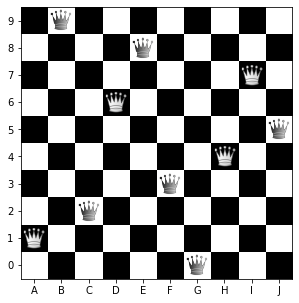

In [9]:
all_var = [sol.get_var_solution('line_'+str(i)) for i in range(10)]
my_values = [v.value for v in all_var]
display_queens(my_values)

## 2. Comparison of the two models

We will compare the two models properly. 

**Exercice:** Consider the `run(model, params)` function that we used in the first tutorial and paste it here.

In [10]:
from docplex.cp.parameters import CpoParameters


def run(model: CpoModel, params: CpoParameters):

    return model.solve(TimeLimit=params.TimeLimit, LogPeriod=params.LogPeriod)

### 2.1. Basic comparison

To compare the two models, we will fix the time limit to 5 seconds, i.e. `TimeLimit=5`, while keeping all the other parameters to their default values.

**Exercice:** Compare the two models for $N \in \{200, 400, 600, .., 2000 \}$. 

<div class="alert alert-block alert-info">
    
By *comparing* we mean plotting the runtime **and** the number of decisions made by the solver for each model as a function of $n$
    
</div>

In [11]:
N = [200*i for i in range(1, 6)]
sols = {'decomposition': [], 'global': []}
params = CpoParameters(TimeLimit=5, LogPeriod=100000,)

for n in N:
    print(n)
    sols['decomposition'] += [run(decomposition_model(n), params)]
    sols['global'] += [run(global_constraint_model(n), params)]

200
400
600
800
1000


**Question:** What do you observe? Why? 

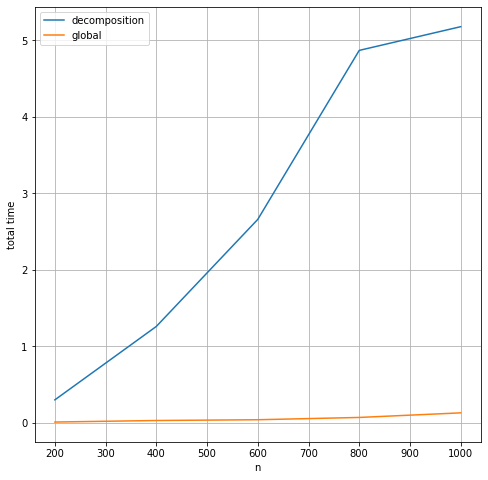

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(N, [sol.get_solver_infos()['TotalTime']
             for sol in sols['decomposition']], label='decomposition')
plt.plot(N, [sol.get_solver_infos()['TotalTime']
             for sol in sols['global']], label='global')
plt.grid(True)
plt.legend()
plt.xlabel('n')
plt.ylabel('total time')
plt.show()

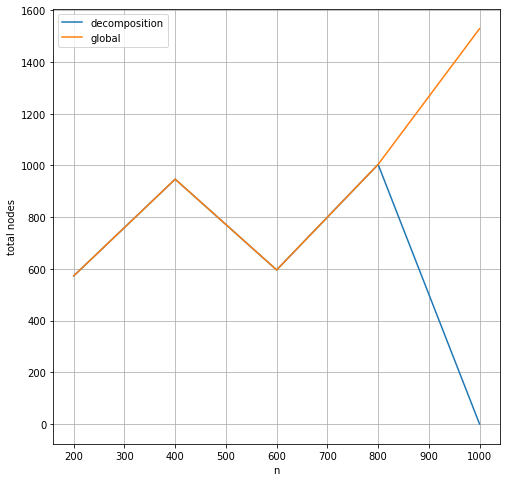

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(N, [sol.get_solver_infos()['NumberOfChoicePoints']
             for sol in sols['decomposition']], label='decomposition')
plt.plot(N, [sol.get_solver_infos()['NumberOfChoicePoints']
             for sol in sols['global']], label='global')
plt.grid(True)
plt.xlabel('n')
plt.ylabel('total nodes')
plt.legend()
plt.show()

from n = 1000, The decomposition model don't even have time to make one choice before the time limit of 5 seconds  that is why its number of choice points is equal to zero. If we had not set any timelimit, the number of choice points would have been greater than the global model's number of choice points.

### 2.2. Branching strategies

**Important:** Before you start this part, please ask one of your supervisors to check on your work.

A CP solver is, at the end of the day, a backtracking solver. At each node, it applies filtering (called also propagation or pruning), then make a decision about the next node to explore. This decision is a pure heuristic choice, that is, it could be a wrong decision, it is only based on intuition. 

In CP, a decision is, most of the times, of the type: choose an unassigned variable $x$, choose a value $v$ from the current domain of $x$, and assign $v$ to $x$. These steps require a variable heuristic and a value heuristic. This is what we call branching strategy. 

Branching strategies can be generic (strategies that can be used for any problem), or specific (designed for the problem at hand). In CPOptimizer, there are a number of genereic strategies offered. This concerns both variable and value heuristics. 

For example, if $L$ is the list of decision variables, then by declaring a search_phase as follows: 

```python
SearchPhase= model.search_phase(L, 
                                varchooser=model.select_smallest(model.domain_size()),
                                valuechooser=model.select_random_value())

model.add_search_phase(SearchPhase)
```

The variable heuristic here is the one that picks the variable $x$ with the smallest domain size, and assigns a random value from its domain to it. 


Read about the different search strategies here: 
http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#search-phases


We want to evaluate different strategies: 
- For variable evaluators, we will use 
 - `domain_size()`
 - `var_impact()`
 - `var_local_impact()`
 - `var_index()`
 
- For value evaluators, we will use 
 - `value_impact()`
 - `value_index()`
 
As for the selectors we will use : 
- `select_smallest()` 
- `select_largest()`

**Question:** How many strategies are we going to evaluate? 

$4*2*2*2 = 32$

**Question:** In addition to the above strategies, we will use also a pure random selection for variables and values. How can we use such a branching heuristic? 

In [14]:
def run(model: CpoModel, params: CpoParameters):
    sol = model.solve(TimeLimit=params.TimeLimit, SearchType=params.SearchType)
    return([sol.get_solver_infos()['NumberOfChoicePoints'], sol.get_solver_infos()['TotalTime'], sol.get_solver_infos()['SearchStatus']])

In [15]:
import itertools


def run(model: CpoModel, params: CpoParameters):
    sol = model.solve(TimeLimit=params.TimeLimit, LogPeriod=params.LogPeriod,
                      SearchType="DepthFirst").get_solver_infos()
    return [sol['NumberOfChoicePoints'], sol['TotalTime'], sol['SearchStatus']]


results = []
N = 20
mdl = global_constraint_model(N)
names_vare = ["domain size", "var impact", "var local", "var index"]
names_vale = ["value impact", "value_index"]
names_vals = ["select_smallest", "select_largest"]
names_vars = ["select_smallest", "select_largest"]

vare = [mdl.domain_size(), mdl.var_impact(), mdl.var_local_impact(),
        mdl.var_index(mdl.get_all_variables())]
vale = [mdl.value_impact(), mdl.value_index(range(N))]
vals = [mdl.select_smallest, mdl.select_largest]
vars = [mdl.select_smallest, mdl.select_largest]

all_search = list(itertools.product(vare, vale, vals, vars))
all_names = list(itertools.product(
    names_vare, names_vale, names_vals, names_vars))

for(variable_evaluator, value_evaluators, value_selector, variable_selector) in all_search:
    mdl = global_constraint_model(N)
    SearchPhase = mdl.search_phase(mdl.get_all_variables(),
                                   varchooser=variable_selector(
                                       variable_evaluator),
                                   valuechooser=value_selector(value_evaluators))
    mdl.add_search_phase(SearchPhase)
    results += [run(mdl, CpoParameters(TimeLimit=5, LogPeriod=100000))]


for i in range(len(all_names)):
    print("Choix = ", all_names[i])
    print("runtime : ", results[i][1])
    print("nombre de décisions : ", results[i][0])
    print('\n')

Choix =  ('domain size', 'value impact', 'select_smallest', 'select_smallest')
runtime :  0
nombre de décisions :  43


Choix =  ('domain size', 'value impact', 'select_smallest', 'select_largest')
runtime :  1.21
nombre de décisions :  325382


Choix =  ('domain size', 'value impact', 'select_largest', 'select_smallest')
runtime :  0
nombre de décisions :  43


Choix =  ('domain size', 'value impact', 'select_largest', 'select_largest')
runtime :  1.23
nombre de décisions :  325382


Choix =  ('domain size', 'value_index', 'select_smallest', 'select_smallest')
runtime :  0
nombre de décisions :  43


Choix =  ('domain size', 'value_index', 'select_smallest', 'select_largest')
runtime :  1.25
nombre de décisions :  325382


Choix =  ('domain size', 'value_index', 'select_largest', 'select_smallest')
runtime :  0
nombre de décisions :  43


Choix =  ('domain size', 'value_index', 'select_largest', 'select_largest')
runtime :  1.24
nombre de décisions :  325382


Choix =  ('var impact', 

In [16]:
import numpy as np
print("Meilleur choix : ")
print(all_names[np.argmin(r[0] for r in results)])
print("Nombre de décisions : ", min(r[0] for r in results))

Meilleur choix : 
('domain size', 'value impact', 'select_smallest', 'select_smallest')
Nombre de décisions :  43


/home/prembamrung/anaconda3/envs/plne/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  # Remove the CWD from sys.path while we load stuff.


[]

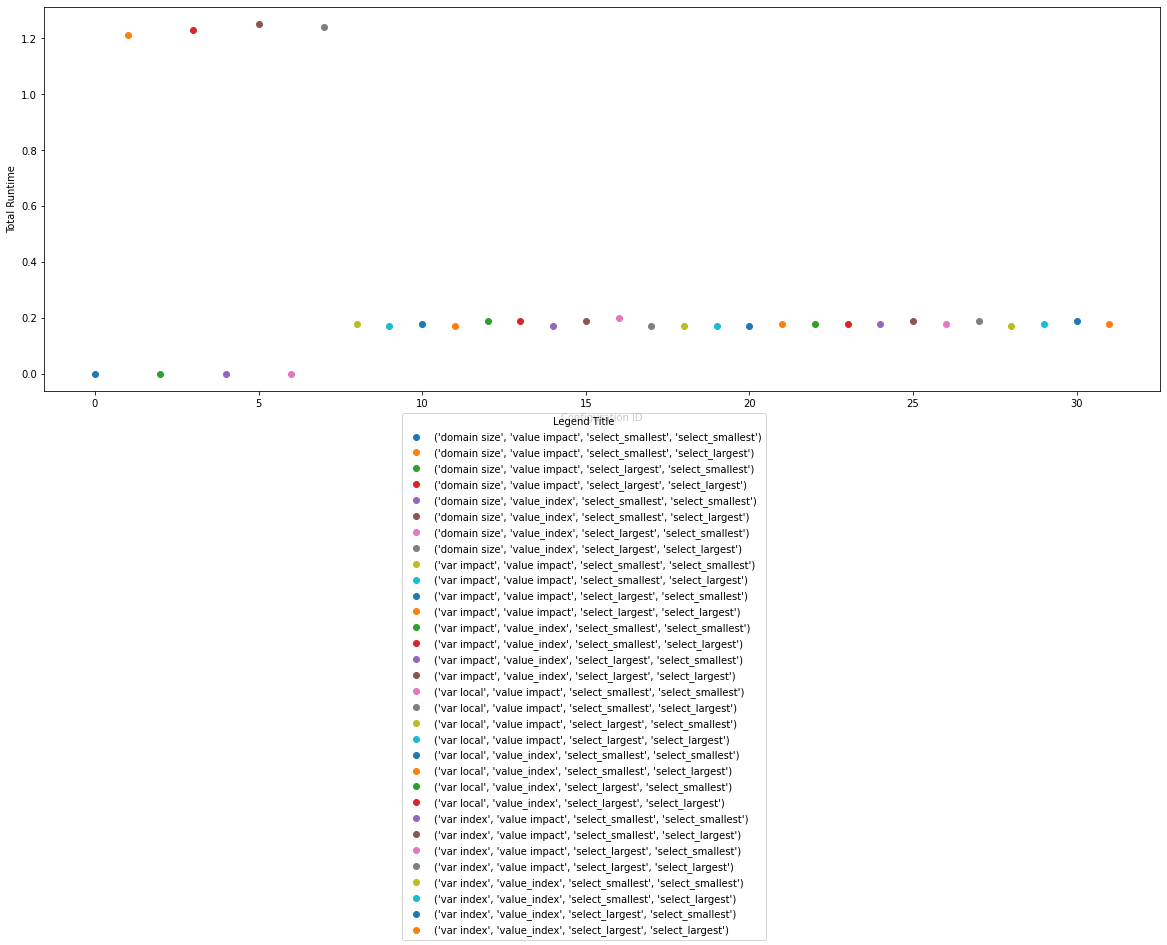

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
labels = all_names
plt.subplot(211)
for i in range(len(results)):
    plt.plot(i, results[i][1], 'o')

fig.legend(all_names,
           labels=labels,
           loc="lower center",
           title="Legend Title")
plt.subplots_adjust(top=1.3)
plt.xlabel("Configuration ID")
plt.ylabel("Total Runtime")
plt.plot()

/home/prembamrung/anaconda3/envs/plne/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  # Remove the CWD from sys.path while we load stuff.


[]

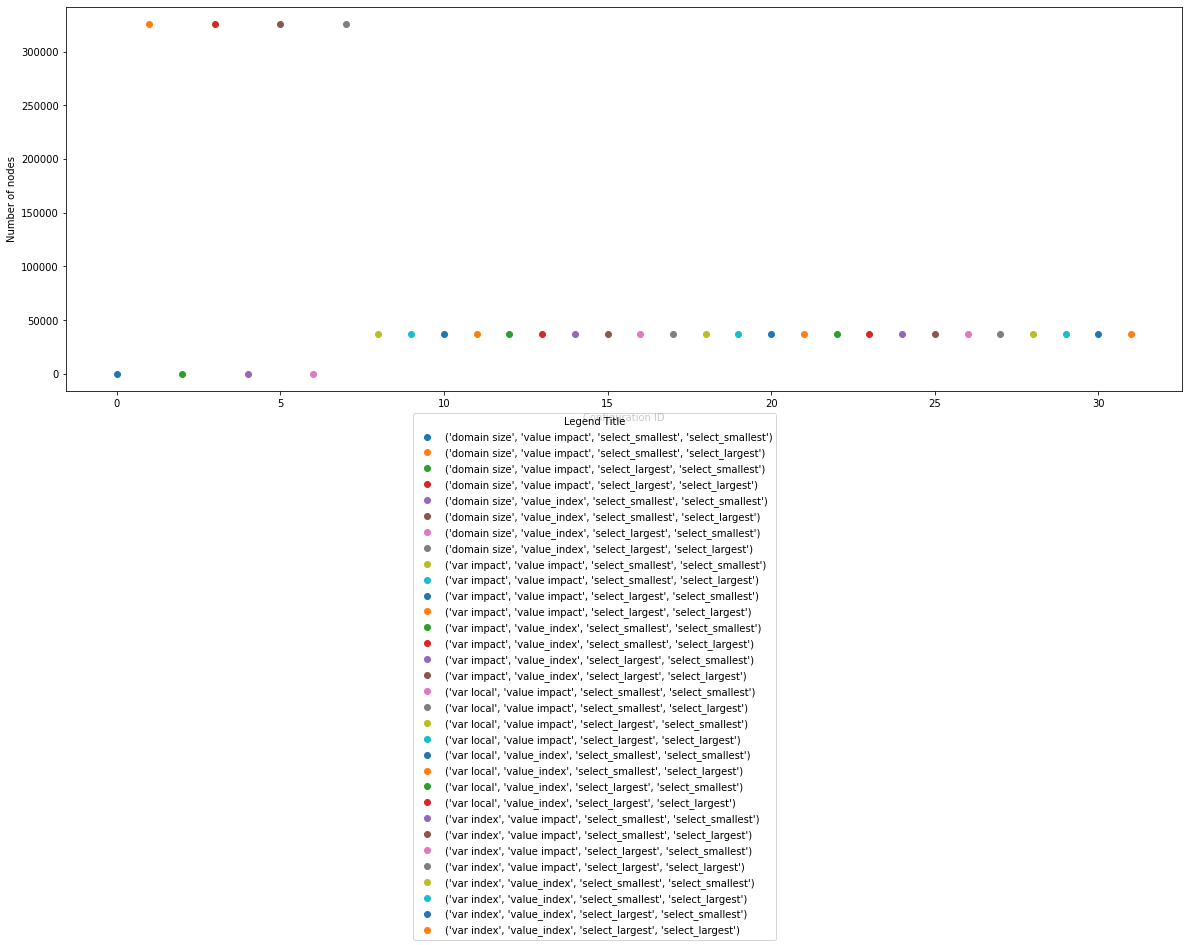

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
labels = all_names
plt.subplot(211)
for i in range(len(results)):
    plt.plot(i, results[i][0], 'o')

fig.legend(all_names,
           labels=labels,
           loc="lower center",
           title="Legend Title")
plt.subplots_adjust(top=1.3)
plt.xlabel("Configuration ID")
plt.ylabel("Number of nodes")
plt.plot()

Using the global constraints model, run the different strategies (**all of them, and pure random**) for different values of $N$. Make sure you choose a good value of $N$ that can assess your claims of evaluation. Feel free to use any reasnable time limit. 

<div class="alert alert-block alert-danger">

**Important:** For this exercice, you must set the `SearchType` to `DepthFirst` using `SearchType="DepthFirst"` when calling `run`.

We will investigate deeply this choice in the next tutorial. But at this stage you should trust us and include it in the solver's parameters.
    
</div>

**Exercice:** Present the results (rutime + number of nodes) via a table first then using plots. 

**Question:** Is this what you expect? Is the choice of the branching strategy important? Justify.

Yes this is what was expected and the branching strategy is important because it reduces the problem and therefore the resolution time considerably. (See graphs)

**Question:** What is more important, the variable ordering or the value ordering choice? Justify.

The ordering variable because we can see an important difference when we switch to 'select_largest' for 'domain size'.

**Question:** What is the best variable ordering choice? Justify.

'domain size' in cases where variables are selected in select_smallest

**Question:** What is the best value ordering choice? Justify.

In this case it seems that it doesn't matter. (No difference between the two in the graphs)

**Question:** What is a good branching overall? Any thoughts why this is the case? Justify.

'domain size', 'value impact', 'select_smallest', 'select_smallest'

**Question:** Did you observe an opposite behaviour of heuristics betwen the runtime and the number of nodes? 
For instance, is there a strategy that is faster than others to solve the problem but requires a larger number of nodes? 
And conversely, is there a heuristic that is slow to solve the problem than others but uses less nodes? 
If you observe this, why is this happening?

We don't observe any of this. On the other hand for the same number of nodes there are some slight time fluctuations which must be due to the machine.

## 3. Conclusion

**Question:** What did you learn today? 

Concerning the N-Queens problem,what we saw during the first tutorial has been proven again in this one. It is very important to use the global constraints in order to reduce the runtime and the number of choice points. These results are shown in the two figures of the 'Basic comparison" part.

In this tutorial we also noticed the importance of the choice of the branching strategy. More precisely, the solver did 43 choices with the best strategy and more than 300000 choices with the worst one. We noticed that the order of the variables is way more important than the values order.Indeed: 

"Choix =  ('domain size', 'value impact', 'select_smallest', 'select_smallest')
runtime :  0.01
nombre de décisions :  43


Choix =  ('domain size', 'value impact', 'select_smallest', 'select_largest')
runtime :  0.99
nombre de décisions :  325382"

In these two lines, we only changed the variable_selector and the number of choice points increased a lot.

On the other hand, changing the variable_evaluator gave thise line:

"Choix =  ('var impact', 'value impact', 'select_smallest', 'select_smallest')
runtime :  0.15
nombre de décisions :  37330"

The number of choice points is still higher than the best strategy's number of choice points but the difference is smaller than the one obtained changing the variable_selector.





<div class="alert alert-block alert-danger"></div>